In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [8]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
# Normalize and Reshape
# Normalize

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [10]:
# Reshape

img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 # Grey scale data
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

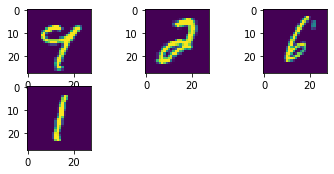

In [19]:
#View a few images
plt.figure(1)
plt.subplot(331)
plt.imshow(x_train[54][:,:,0])

plt.subplot(332)
plt.imshow(x_train[555][:,:,0])

plt.subplot(333)
plt.imshow(x_train[6789][:,:,0])

plt.subplot(334)
plt.imshow(x_train[42000][:,:,0])
plt.show()

In [21]:
# Build the model
## Encoder
## Define 4 conv2D, flatten and ten dense
latent_dim = 2 # Number of latent dimension parms(latent space is a 2D plane)
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) # Shape of conv to be provided to decoder
# Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
